# Shrinkage Methods (Linear Regression -- Loan Club Dataset)

As a expansion of subset selection methods, we introduce shrinkage methods and dimensionaltiy reduction. These methods are appropriate for datasets with large number of features where manual exploration become infeasible.

Unlike subset selection methods, shrinkage methods can offer a continous selection rather than discrete selection (take or leave) of the features. This would result in a better models. Shrinkage methods can also reduce time complexity required for exploring all possible subsets in case of best subset selection.

We also explore PCA as a dimensionality reduction technique that can extract only principal components from the data to develop a better linear regression models.

Through this notebook, we also explore concepts of scaling, k-fold cross validation, and pipe lines.

### Load libraries:

In [1]:
import itertools
import pandas as pd
import numpy as np
import copy
import time

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Reset all styles to the default:
plt.rcParams.update(plt.rcParamsDefault)
# Then make graphs inline:
%matplotlib inline

def displaybd(text):
    display(Markdown("**" + text + "**"))

In [2]:
# Set custom style settings:
# NB: We need to separate "matplotlib inline" call and these settings into different
# cells, otherwise the parameters are not set. This is a bug somewhere in Jupyter
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.markersize'] = 10

## 1. Data:

### Get and Clean the Data

In addition to the features used in the previous notebook, we include all other numerical features in the dataset. A log transformation was performed on these features. This can show the power of shrinkage methods in determining the most signifincant parameters  

In [3]:
#-- LOAD DATA:

# Load sampled and cleaned loan club dataset
datetime_cols = ['issue_d','last_pymnt_d']
loan_club = pd.read_csv('Loan_sampled_cleaned.csv',parse_dates = datetime_cols)
loan_club_fully_paid = loan_club[loan_club['loan_status']=='Fully Paid'].reset_index(drop=True)
loan_club_fully_paid['loan_period'] = loan_club_fully_paid['last_pymnt_d'] - loan_club_fully_paid['issue_d']
loan_club_fully_paid['loan_period'] = loan_club_fully_paid['loan_period'] / pd.to_timedelta(1, unit='D')



# Select skewed regressors that should have log transformation. 
colsToLn = list(loan_club_fully_paid.select_dtypes(include=[np.number]).columns)
colsToLn.remove('loan_period')
colsToLn.remove('int_rate')
colsToLn.remove("percent_bc_gt_75")
colsToLn.remove("bc_util")

# Log transform
ln_cols = []
for colName in colsToLn:
    lnColName = "ln_" + colName
    loan_club_fully_paid[lnColName] = np.log(np.exp(1)+loan_club_fully_paid[colName])
    loan_club_fully_paid.drop([colName], axis=1,inplace = True)
    ln_cols.append(lnColName)
# Convert categorical variables into dummies:
dummies = pd.get_dummies(loan_club_fully_paid[['term']])
X = loan_club_fully_paid[ln_cols+['int_rate','percent_bc_gt_75','bc_util','loan_period']].drop(['ln_total_pymnt'], axis=1)
cat_features = ['term_ 36 months']

# Extract predictors and outcome variables
X = pd.concat([X, dummies[cat_features]], axis=1)
feature_names = X.columns
y = loan_club_fully_paid.ln_total_pymnt
    
display(X[0:10],y[0:10])

print('Data shape: ', X.shape)

,ln_loan_amnt,ln_annual_inc,ln_dti,ln_delinq_2yrs,ln_inq_last_6mths,ln_open_acc,ln_pub_rec,ln_revol_bal,ln_revol_util,ln_total_acc,...,ln_pub_rec_bankruptcies,ln_tax_liens,ln_total_bal_ex_mort,ln_total_bc_limit,ln_total_il_high_credit_limit,int_rate,percent_bc_gt_75,bc_util,loan_period,term_ 36 months
0,8.854054,11.775311,2.508646,1.000000,1.743668,2.461150,1.000000,7.217970,3.456893,3.357534,...,1.000000,1.0,10.950240,8.007273,11.699527,14.33,50.0,45.4,911.0,1
1,10.126740,11.289816,3.172131,1.000000,1.000000,3.078154,1.313262,9.875794,3.763947,3.456893,...,1.313262,1.0,10.469816,10.122732,10.440528,11.49,42.9,55.4,577.0,0
2,8.517737,11.289816,2.890832,1.313262,1.000000,2.618729,1.000000,8.746035,3.567228,3.547266,...,1.000000,1.0,10.398785,9.648771,10.532755,5.32,0.0,32.9,1066.0,1
3,10.463181,11.813050,3.208352,1.000000,1.000000,2.816503,1.313262,9.428409,3.553011,3.487934,...,1.000000,1.0,11.162030,10.529499,11.292300,14.31,16.7,33.2,821.0,1
4,8.699968,10.645490,3.229946,1.000000,1.000000,2.461150,1.000000,8.790378,4.206456,3.424858,...,1.000000,1.0,11.053659,7.315031,11.073951,13.66,100.0,101.8,1126.0,1
5,10.126740,12.072557,2.952735,1.551445,1.000000,3.078154,1.000000,7.846480,2.435216,3.777766,...,1.000000,1.0,11.120530,8.779976,11.431604,11.55,0.0,0.0,153.0,1
6,9.998921,11.626278,2.486429,1.000000,1.000000,3.207543,1.000000,10.343892,3.941937,3.656312,...,1.000000,1.0,10.343892,10.341830,1.000000,8.18,50.0,64.7,519.0,0
7,9.451537,10.534832,3.005102,1.000000,1.000000,2.543040,1.000000,9.477288,4.048620,3.630145,...,1.000000,1.0,10.659626,8.294729,10.275938,14.49,0.0,0.0,212.0,1
8,10.463181,11.849417,3.231527,2.371951,1.313262,2.754824,1.313262,9.073801,3.844136,4.038097,...,1.000000,1.0,12.283976,9.510646,12.263250,16.29,25.0,64.6,1127.0,1
9,9.433701,10.126740,3.572297,1.000000,1.000000,2.689090,1.000000,9.323108,3.976279,3.207543,...,1.000000,1.0,9.353897,9.554123,9.681139,10.99,20.0,53.5,943.0,1


0     9.060828
1    10.278455
2     8.598076
3    10.660833
4     8.902444
5    10.170038
6    10.097493
7     9.527945
8    10.702820
9     9.569199
Name: ln_total_pymnt, dtype: float64

Data shape:  (33887, 52)


**The data has 33887 observations with 52 features.** 

### Split the data:
To validate our model performance on generalizing to unknown data, we need to to have some test subset for evaluating our model. We split our data into training and test subsets. Within the training data, we can use some validation subset to perform cross-validation for parameters tuning.  
We split the data into 2/3 for training, and 1/3 for testing.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
print("No. training samples", X_train.shape[0])
print("No. testing samples", X_test.shape[0])

No. training samples 22704
No. testing samples 11183


### Scaling the data:

Shrinkage models like Lasso and Ridge requires data to be normalized to reduce bias towards certain features if they have different scales.  
We use the "StandardScaler" method from Sklearn which normilizes the data by substracting the mean and dividing by the standard deviation.  
We fit our "scaler" on the X_train data and then apply it to the X_test.

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Ridge:

Ridge regression is a shrinkage method for linear regression where the sum of squared regression coefficients is minimized besides the residual sum of squares (RSS). 
\begin{equation}
  J = RSS + \lambda \sum_j \beta_j^2.
\end{equation}

The hyperparameter $\lambda$ penalizes large coefficients to regularize the model. This can offer a trade-off between bias and variance. A high value of $\lambda$ results in nearly zero coefficients, so the model becomes highly-biased. On the other hand, A low value of $\lambda$ results in nearly no shrinkage of coefficients which might results in high variance of the model.  

The parameter $\lambda$ can be tuned to minimize the MSE (trade-off between bias and variance). We create list of different values of lambda to compare different models.  

10-fold cross validation within the training data is used to avoid overfitting to the data. To ensure the scaling is unbiased, we create a "pipeline" to first scale each training fold before fitting the model to it. The validation data within the same fold is then scaled using the same scaler. The model performance is evaluated using MSE on the validation set. 

In [6]:
# Use the Ridge method from Sklearn linear models
ridge = Ridge()
# create a grid of different values of lambda (alphas for sklearn)
alphas = np.logspace(-3, 3, 50)
#create a pipline to perform scaling then regression.
pipe = Pipeline(steps=[('scale', scaler), ('ridge', ridge)])
# use 10-fold cross validation
params = {'ridge__alpha': alphas}
ridge_clf = GridSearchCV(pipe, params, cv=10,scoring='neg_mean_squared_error')
#fit the model
ridge_clf.fit(X_train, y_train);

Now, that we fitted our model, we can select the best $\lambda$ than minimize our MSE.

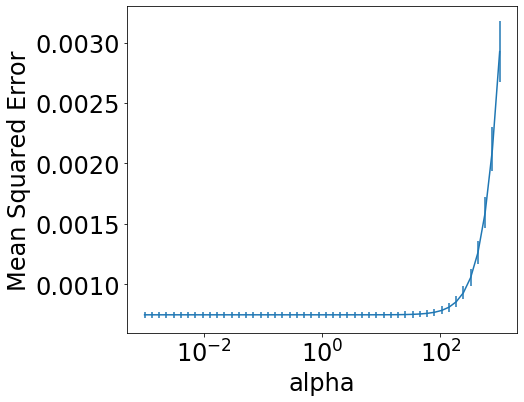

In [7]:
plt.errorbar(alphas,-ridge_clf.cv_results_['mean_test_score'],-ridge_clf.cv_results_['std_test_score'])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error');

For low values of $\lambda$, the MSE is low since we use most of our features with limited shrinkage. As $\lambda$ increases, no significant change in MSE is noted. Around $\lambda = 10^2$, the MSE started to increase as the coefficients start shrinking significantly.

Eventhough there are very little variations, we can still choose our best ridge regressor as the one that gives the lowest MSE.

### Best Ridge model: 

We can now fit a model on the complete training data using our optimized parameter from cross validation.

In [8]:
print("Best Ridge alpha: ", ridge_clf.best_params_)
print("Best Ridge MSE: ", -ridge_clf.best_score_)

Best Ridge alpha:  {'ridge__alpha': 0.49417133613238334}
Best Ridge MSE:  0.0007475496997178675


The optimum $\lambda$ is about 0.5 with an MSE of about 0.00075.

Let's fit a model using the full training subset.

In [9]:
ridge_best = Ridge(alpha = ridge_clf.best_params_['ridge__alpha'])
ridge_best.fit(X_train_scaled,y_train);

Let's see the Ridge regression model coefficients. 

In [10]:
print('Ridge Model Coefficients: ')
ridge_best.coef_

Ridge Model Coefficients: 


array([ 6.70819014e-01,  3.28440823e-04,  5.06608211e-04,  2.37503920e-04,
        9.15328704e-04, -1.97809189e-03,  7.63638048e-04,  8.36339586e-04,
       -2.42510045e-03,  3.98955393e-04,  0.00000000e+00,  3.04132921e-02,
        1.25726907e-03,  0.00000000e+00,  1.43971170e-02,  1.72362451e-04,
       -2.42609199e-04,  2.18697070e-03, -6.52920820e-04,  1.79311917e-05,
       -1.79053228e-03, -1.72523715e-03, -1.10860298e-04,  8.35383986e-05,
       -2.51811280e-04, -3.36189507e-04,  3.89520278e-04, -4.86205748e-04,
       -4.20148143e-05, -5.65317389e-04, -2.75359591e-04, -1.06727528e-04,
       -2.14870252e-03,  1.68882566e-03,  1.78852270e-03,  8.67962193e-05,
        4.62381619e-04, -7.77549685e-04,  3.12832333e-04, -2.80422531e-04,
       -4.88401915e-04,  2.38645149e-05, -4.22351107e-04, -2.64883938e-04,
       -1.10797714e-03,  1.83670432e-04,  3.44511084e-04,  3.37261525e-02,
        1.17944818e-03, -2.03411762e-04,  5.57345583e-02, -8.95081864e-03])

Most of the coefficients are relatively small, and won't have a significant effect on the outcome. Let's inspect the most significant features of our model.

In [11]:
feature_names[np.abs(ridge_best.coef_) > 0.005] #0.005 is a rough value.

Index(['ln_loan_amnt', 'ln_total_rec_int', 'ln_last_pymnt_amnt', 'int_rate',
       'loan_period', 'term_ 36 months'],
      dtype='object')

These six features are the most significant out of the original 52 features. This set features include the same features from our best subset selection model, in addition to two other features ("ln_total_rec_int", "ln_last_pymnt_amnt")

## 3. Lasso:

Lasso regression is a shrinkage method similiar to Ridge regression; however, unlike Ridge, Lasso minimizes the sum of absolute regression coefficients. 
\begin{equation}
  J = RSS + \lambda \sum_j|\beta_j|.
\end{equation}

Similar to Ridge regression, tuning the hyperparameter $\lambda$ regularize the model to offer a trade-off between bias and variance. Unlike Ridge, Lasso regression would result in exactly zero coefficients which can lead to a sparse model that helps us identify the most significant parameters. 

Scaling and cross-validation process for Lasso is performed exactly as for Ridge (previous section).

In [12]:
# Use the Lasso method from Sklearn linear models
lasso = Lasso()
# create a grid of different values of lambda (alphas for sklearn)
alphas = np.logspace(-3, 3, 50)
#create a pipline to perform scaling then regression.
pipe = Pipeline(steps=[('scale', scaler), ('lasso', lasso)])
# use 10-fold cross validation
params = {'lasso__alpha': alphas}
lasso_clf = GridSearchCV(pipe, params, cv=10,scoring='neg_mean_squared_error')
#fit the model
lasso_clf.fit(X_train, y_train);

Now, that we fitted our model, we can select the best $\lambda$ than minimize our MSE.

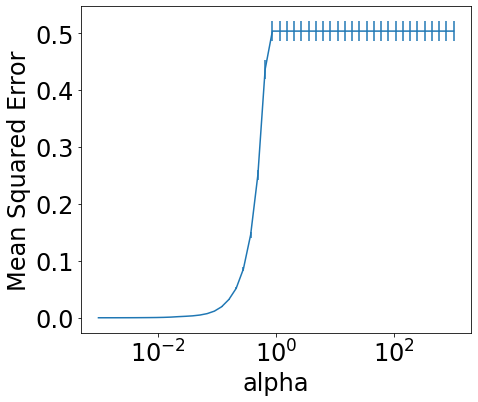

In [13]:
plt.errorbar(alphas,-lasso_clf.cv_results_['mean_test_score'],-lasso_clf.cv_results_['std_test_score'])
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error');

For low values of $\lambda$, the MSE is low since we use most of our features with limited shrinkage. As $\lambda$ increases, no significant change in MSE is noted. The MSE started to increase around $\lambda = 0.1$, as the coefficients start shrinking significantly. Around $\lambda = 1$, the MSE saturated as all coefficients has become zero except for the intercept. 

Eventhough there are very little variations, we can still choose our best lasso regressor as the one that gives the lowest MSE.

### Best Lasso model: 

We can now fit a model on the complete training data using our optimized parameter from cross validation.

In [14]:
print("Best Lasso alpha: ", lasso_clf.best_params_)
print("Best Lasso MSE: ", -lasso_clf.best_score_)

Best Lasso alpha:  {'lasso__alpha': 0.001}
Best Lasso MSE:  0.000758826654987639


The optimum $\lambda$ is 0.001 with an MSE of about 0.00076.

Let's fit a model using the full training subset.

In [15]:
lasso_best = Lasso(alpha = lasso_clf.best_params_['lasso__alpha'])
lasso_best.fit(X_train_scaled,y_train);

Let's see the Lasso regression model coefficients. 

In [16]:
print('Lasso Model Coefficients: ')
lasso_best.coef_

Lasso Model Coefficients: 


array([ 6.68876685e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.01010000e-04, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.33519928e-02,
        3.09700618e-04,  0.00000000e+00,  1.17172615e-02,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.60743811e-04, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  3.27033024e-02,
        0.00000000e+00,  0.00000000e+00,  5.15950720e-02, -8.88634502e-03])

Most of the coefficients are exactly zero, and will have no effect on the outcome. Let's inspect the most significant features of our model.

In [17]:
feature_names[np.abs(lasso_best.coef_) > 0.005]

Index(['ln_loan_amnt', 'ln_total_rec_int', 'ln_last_pymnt_amnt', 'int_rate',
       'loan_period', 'term_ 36 months'],
      dtype='object')

These six features for Lasso are the same as the ones obtained from Ridge.

## 4. PCR:

PCR is based on using Principal Component Analysis (PCA) to reduce the number of features, then a linear regression model is based on the reduced features.  
The principal componets from PCA can explain a percentage of variance of the original features. The more number of principal components, the higher the explained variance becomes. Thus, the No. principal components can significantly affect the quality of the PCR model. A relatively small No. of components will result in a biased model, while increased No. of components increases variance. 

We can perform K-fold cross validation on scaled training data to tune the No. of components hyperparamter that minimizes the MSE as shown for Ridge and Lasso.

In [18]:
# Use the PCA method from Sklearn decomposition
pca = PCA()
# Use the Linear Regression method from Sklearn linear models
linear = LinearRegression()
# create a pipeline to perform standard scaling >> principal component analysis >> linear regression
pipe = Pipeline(steps=[('scale', scaler),('pca', pca), ('linear', linear)])
# create a grid of number of components
comps = np.arange(1,X_train.shape[1])[::-1]
# run 10-fold cross validation
params = {'pca__n_components': comps}
pcr_clf = GridSearchCV(pipe, params, cv=10,scoring='neg_mean_squared_error')
# fit the model
pcr_clf.fit(X_train, y_train);

Now, that we fitted our model, we can select the best $n\_components$ than minimize our MSE.

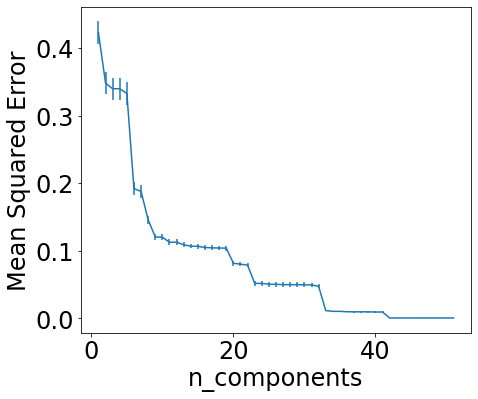

In [19]:
plt.errorbar(comps,-pcr_clf.cv_results_['mean_test_score'],-pcr_clf.cv_results_['std_test_score'])
plt.xlabel('n_components')
plt.ylabel('Mean Squared Error');

The graph shows a nearly monotonic behaviour between the n_components and the MSE. As we add more components, we can explain more variance of the data and get a better model for the data.

This dataset doesn't favor PCR, so we need almost all the features to get an acceptable results.

### Best PCR model: 

We can now fit a model on the complete training data using our optimized parameter from cross validation.

In [20]:
print("Best No. Comps: ", pcr_clf.best_params_)
print("Best MSE: ", -pcr_clf.best_score_)

Best No. Comps:  {'pca__n_components': 49}
Best MSE:  0.0007474297948862259


The optimum $n\_components$ is 49 with an MSE of about 0.00075. These model doesn't differ much from using the full dataset.

Let's fit a model using the full training subset.

In [21]:
pcr_pca = PCA(n_components=pcr_clf.best_params_['pca__n_components'])
pcr_linear = LinearRegression()
pcr_best = Pipeline(steps=[('pca', pcr_pca), ('linear', pcr_linear)])
pcr_best.fit(X_train_scaled,y_train);

## 4. Methods Comparison:

We have explored different shrinkage methods (Ridge and Lasso), and dimensionality reduction (PCA) to develop powerful linear regression models in case of too many features.

We can now compare the perfomance based on the test subset.

In [22]:
y_predicted_ridge = ridge_best.predict(X_test_scaled)
print("Ridge MSE: ", mean_squared_error(y_predicted_ridge,y_test))
print("Ridge R2: ", ridge_best.score(X_test_scaled,y_test),"\n")

y_predicted_lasso = lasso_best.predict(X_test_scaled)
print("Lasso MSE: ", mean_squared_error(y_predicted_lasso,y_test))
print("Lasso R2: ", lasso_best.score(X_test_scaled,y_test),"\n")

y_predicted_pcr = pcr_best.predict(X_test_scaled)
print("PCR MSE: ",mean_squared_error(y_predicted_pcr,y_test))
print("PCR R2: ", pcr_best.score(X_test_scaled,y_test))


Ridge MSE:  0.0007685427835530755
Ridge R2:  0.9984591748553104 

Lasso MSE:  0.0007809762956389856
Lasso R2:  0.9984342473321214 

PCR MSE:  0.0007684236232185001
PCR R2:  0.9984594137557904


All of the models have almost the same performance with a very low MSE and a very high $R^2$.
We expect shrinkage methods like lasso and ridge to perform better than PCR even for datasets favoring PCR.

We can compare the current model with the best subset model from previous notebook where we found a subset of four predictors that resulted in good results.

In [23]:
best_subet = ['ln_loan_amnt','loan_period','int_rate','term_ 36 months']
X_train_best_subset = X_train[best_subet]
X_test_best_subset = X_test[best_subet]

best_subset_linear = LinearRegression()
best_subset_linear.fit(X_train_best_subset,y_train)

y_predicted_bestsubset = best_subset_linear.predict(X_test_best_subset)
print("Best_Subset MSE: ",mean_squared_error(y_predicted_bestsubset,y_test))
print("Best_Subset R2: ", best_subset_linear.score(X_test_best_subset,y_test))


Best_Subset MSE:  0.0011335793497888593
Best_Subset R2:  0.997727325526914


The performance of shrinkage methods is as good or even better than best subset model. This is due to the fact that with shrinkage methods we can explore more features without high time complexity as for subset selection methods. For Lasso and Ridge, a subset of 6 features were contributing to the outcome which resulted in improved fitness.